# Time series forecasting

In [6]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We will use [sktime](https://www.sktime.net/en/stable/index.html) as our main library for time series. It offers interface very similar to scikit-learn, and conveniently wraps many other libraries, for example:
- [statsforecast](https://github.com/Nixtla/statsforecast) - efficient implementations of many forecasting methods, e.g. AutoARIMA and AutoETS
- [pmdarima](https://alkaline-ml.com/pmdarima/) - statistical tests for time series and another AutoARIMA implementation
- [statsmodels](https://www.statsmodels.org/stable/index.html) - a few time series decomposition and forecasting methods

For statistical tests we will use [scipy](https://docs.scipy.org/doc/scipy/index.html) and [statsmodels](https://www.statsmodels.org/stable/index.html).

## Forecasting Polish inflation

The problem of forecasting inflation (here defined using consumer price index, CPI) is very common, done by basically every country and larger financial institutions. In practice it's not a single task, but rather a collection of related problems, forecasting e.g. inflation, core inflation (excluding most volatile components, e.g. food and energy prices), and other formulations.

In Poland, basic data about inflation [is published by the Central Statistical Office of Poland (GUS)](https://stat.gov.pl/obszary-tematyczne/ceny-handel/wskazniki-cen/wskazniki-cen-towarow-i-uslug-konsumpcyjnych-pot-inflacja-/miesieczne-wskazniki-cen-towarow-i-uslug-konsumpcyjnych-od-1982-roku/), with monthly, quarterly, half-yearly and yearly frequency. More detailed information is published by other institutions, because they depend on the methodology used, e.g. core inflation [is calculated and published by the National Bank of Poland (NBP)](https://nbp.pl/statystyka-i-sprawozdawczosc/inflacja-bazowa/).

Forecasting inflation is a challenge, since it typically:
- has visible cycles, but very irregular
- is implicitly tied to many external factors (global economy, political decisions etc.)
- there is no apparent seasonality
- we are interested in forecasting with many frequencies, e.g. monthly (short-term decisions) and yearly (long-term decisions)

We will use GUS data with monthly frequency. To get a percentage value (annual percentage rate inflation) from the raw data, we need to subtract 100 from provided values.

In [7]:
df = pd.read_csv("polish_inflation.csv")
df = df.rename(columns={"Rok": "year", "Miesiąc": "month", "Wartość": "value"})

# create proper date column
df["day"] = 1
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df["date"] = df["date"].dt.to_period("M")

# set datetime index
df = df.set_index(df["date"], drop=True)
df = df.sort_index()

# leave only time series values
df = df["value"] - 100

# filter out NaN values from the end of the series
df = df[~df.isna()]

df

date
1982-01     53.2
1982-02    106.4
1982-03    110.7
1982-04    104.1
1982-05    108.4
           ...  
2024-04      2.4
2024-05      2.5
2024-06      2.6
2024-07      4.2
2024-08      4.3
Freq: M, Name: value, Length: 512, dtype: float64

To plot the time series, the easiest way is to use the [plot_series() function](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.utils.plotting.plot_series.html) from sktime, which will automatically nicely format X and Y axes.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation'}, ylabel='value'>)

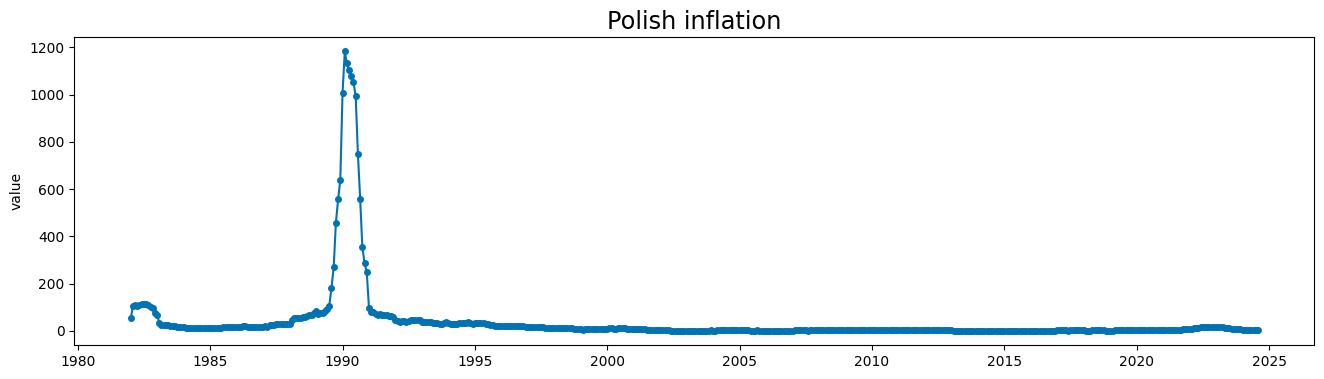

In [8]:
from sktime.utils.plotting import plot_series

plot_series(df, title="Polish inflation")

There is no error here - 90s were a particularly interesting period, with [hyperinflation](https://pl.wikipedia.org/wiki/Hiperinflacja#Polska_%E2%80%93_lata_80._XX_wieku), later ["shock therapy"](https://en.wikipedia.org/wiki/Shock_therapy_(economics)) and implementation of the [Balcerowicz Plan](https://pl.wikipedia.org/wiki/Plan_Balcerowicza). From the perspective of time series forecasting, this is definitely na outlier, but quite long. For this reason, we will limit ourselves to post-2000 data.

Similar behavior can often be seen in time series data, related to e.g. [2007-2008 financial crisis](https://en.wikipedia.org/wiki/2007%E2%80%932008_financial_crisis) or COVID-19 pandemic. Such events can introduce shocks with long effects, and using only later data is arguably the simplest strategy to deal with this.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Polish inflation, from year 2000'}, ylabel='value'>)

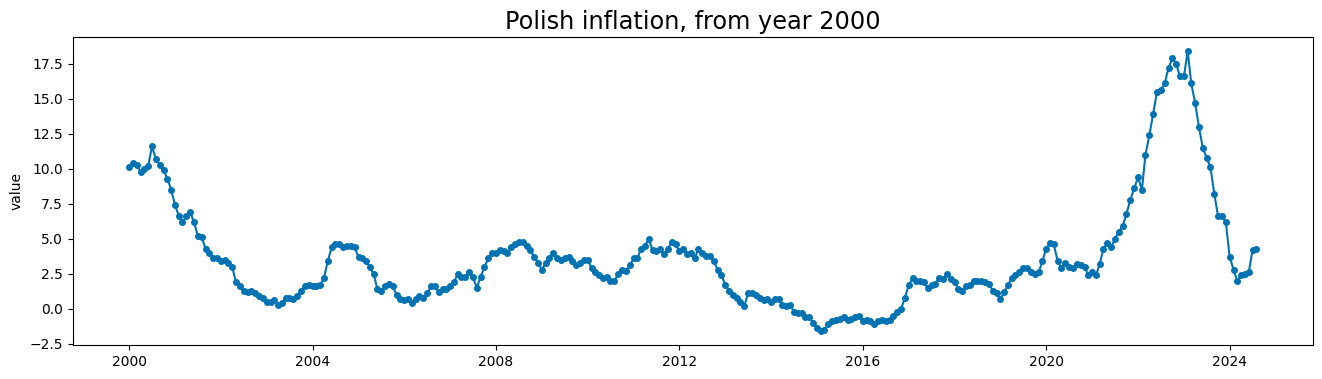

In [9]:
df = df[df.index >= "2000-01"]
plot_series(df, title="Polish inflation, from year 2000")

There is definitely some information here, with cycles and trends. Fortunately, the data seems to be changing reasonably slowly most of the time. But what about seasonality?

**Exercise 1 (0.5 points)**

Implement the `plot_stl_decomposition` function. Use `STLTransformer` to compute the STL decomposition ([documentation](https://www.sktime.net/en/v0.29.0/api_reference/auto_generated/sktime.transformations.series.detrend.STLTransformer.html)). Remember to use appropriate arguments to set the seasonality period and return all three components.

Plot the resulting STL decomposition. Comment:
- do you see a yearly seasonality here?
- concerning residuals, are they only a white noise, or do they seem to contain some further information to use?

In [10]:
from sktime.transformations.series.detrend import STLTransformer

def series_to_floats(series):
    if isinstance(series.index, pd.PeriodIndex):
        data = series.to_timestamp()

    return data.astype(float)


def plot_stl_decomposition(data: pd.Series, seasonal_period: int = 12) -> None:
    data = series_to_floats(data)
    
    transformer = STLTransformer(sp = seasonal_period, return_components=True)
    Xt = transformer.fit_transform(data)

    trend = Xt["trend"]
    seasonal = Xt["seasonal"]
    resid = Xt["resid"]
    
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    fig.suptitle("STL Decomposition Using STLTransformer", fontsize=16)

    axes[0].plot(data, label="Original Data")
    axes[0].legend(loc="upper left")
    axes[0].set_ylabel("Data")

    axes[1].plot(trend, label="Trend", color="orange")
    axes[1].legend(loc="upper left")
    axes[1].set_ylabel("Trend")

    axes[2].plot(seasonal, label="Seasonal", color="green")
    axes[2].legend(loc="upper left")
    axes[2].set_ylabel("Seasonal")

    axes[3].plot(resid, label="Residual", color="red")
    axes[3].legend(loc="upper left")
    axes[3].set_ylabel("Residual")
    axes[3].set_xlabel("Time")

    plt.tight_layout()
    plt.show()

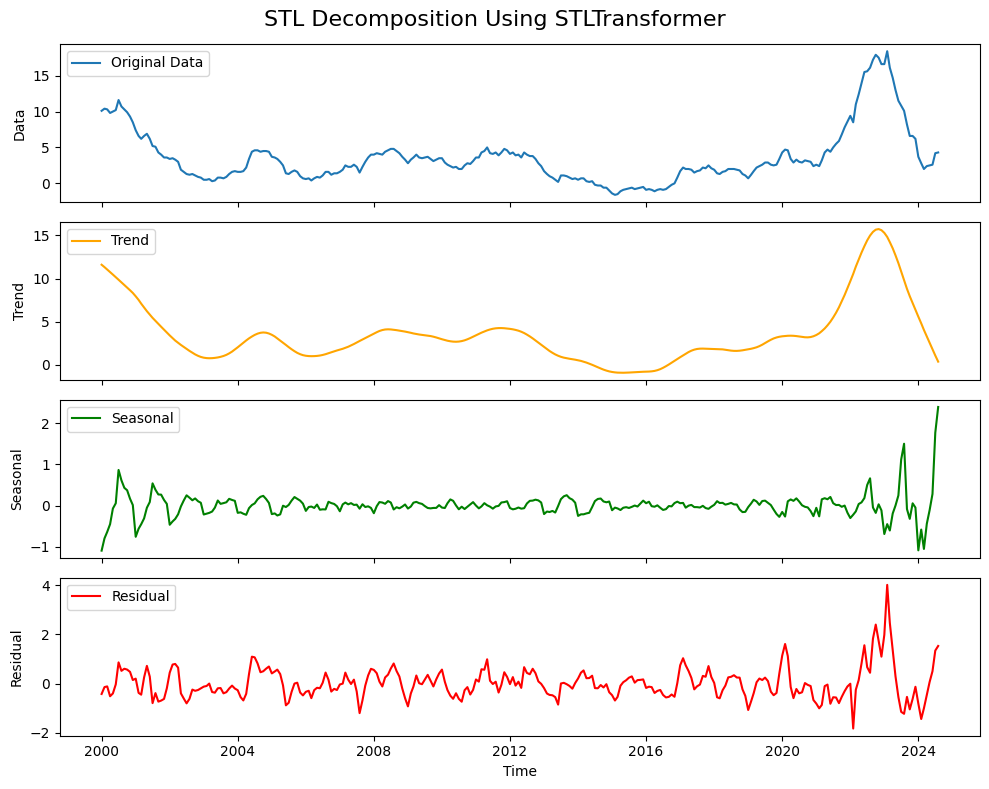

In [11]:
plot_stl_decomposition(df)

// comment here  

It's hard to spot anual seasonality in the chart above. We have instructed `STLTransformer` to find it, so it's done its job, yet the result is so irregular, that I won't call it a success. There is no clear anual seasonability in the inflation data.

In this case the residuals sometimes try to compensate for the invalidly found seasonality. We can spot some residual peaks, where the seasonality reaches its bottoms.  
Besides residuals show the minor data fluctuations connected with some incidents influencing the inflation, like changes in price based on sentiment, people behaviour or general events like the pandemic in 2020.

// comment here  - end

Manual check using STL decomposition is useful - this allows us to gain intuition and knowledge about the data, and validation parameters. Of course we also have automated procedures, using statistical tests, to avoid such manual labor when we can.

Let's check the seasonality and stationarity of our data. This is not strictly necessary for ETS models - they use the data as-is. However, the ARIMA models require stationary data, and knowledge about seasonality, or lack thereof, can greatly accelerate our experiments. SARIMA takes much longer than simpler ARIMA.

**Exercise 2 (0.75 points)**

1. Check, using statistical tests for seasonality, if there is a quarterly, half-yearly, or yearly seasonality in the data. Use the `nsdiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html)). If you detect seasonality, remove it using the `Differencer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.difference.Differencer.html)) and plot the deasonalized series.

2. Check, using statistical tests for stationarity, what differencing order stationarizes the data. Use the `ndiffs` function from pmdarima ([documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html)). If it's greater than zero, i.e. differencing is necessary, then stationarize the series using the `Differencer` class and plot the resulting time series.

3. Comment, which ARIMA model would you use, based on those findings, and why: ARMA, ARIMA, or SARIMA.

Use the default `D_max` and `d_max` values.

**Warning:** create new variables for values after differencing, do not overwrite the `df` variable. It will be used later.

In [12]:
from pmdarima.arima import nsdiffs

seasonal_periods = {
    "quarter": 4,
    "half": 6,
    "year": 12
}

seasonal_diffs = {}
for period, period_val in seasonal_periods.items():
    seasonal_diffs[period] = nsdiffs(df, m=period_val)

for period, diff in seasonal_diffs.items():
    print(f"{period} - seasonality observed" if diff > 0 else f"{period} - seasonality not observed")


quarter - seasonality not observed
half - seasonality not observed
year - seasonality not observed


In [13]:
from pmdarima.arima import ndiffs
from sktime.transformations.series.difference import Differencer

def stationarize(df):
    diff_order = ndiffs(df, test="kpss")

    do_or_dont = "will" if diff_order > 0 else "won't"
    print(f"Diff order: {diff_order}, differencing {do_or_dont} be conducted")

    if diff_order > 0:
        differencer = Differencer(lags=diff_order)
        statio_data = differencer.fit_transform(df)
    else:
        print("No differencing needed; series is already stationary.")
        statio_data = df

    return statio_data

statio_data = stationarize(df)

Diff order: 1, differencing will be conducted


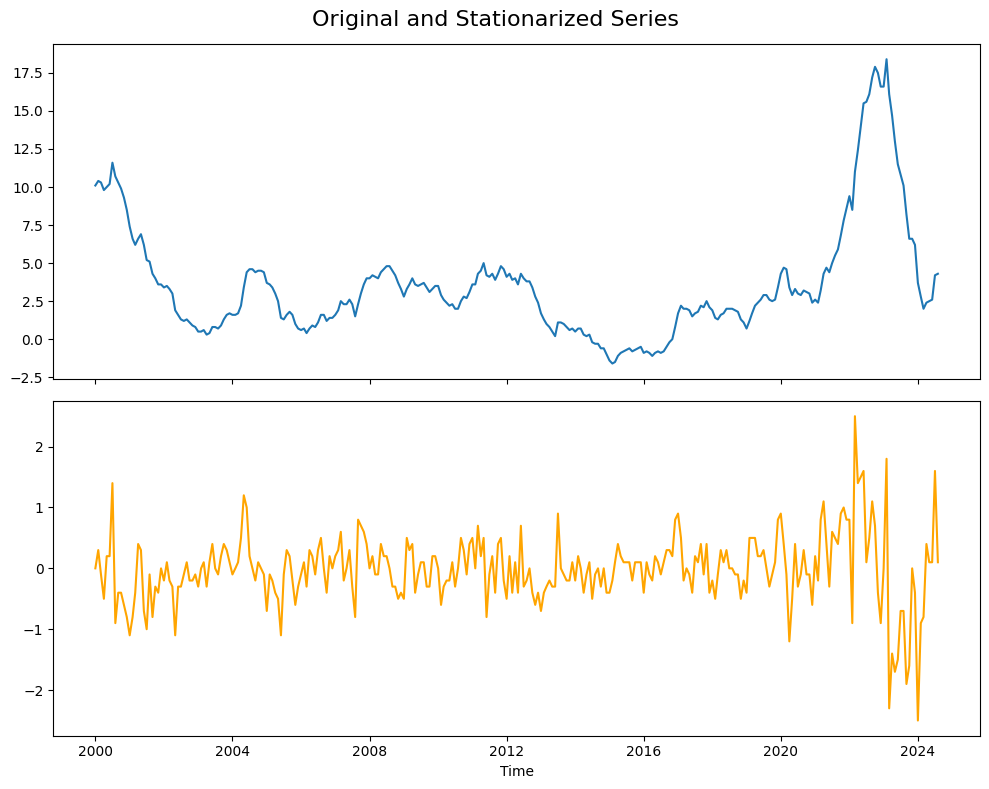

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.suptitle("Original and Stationarized Series", fontsize=16)

data = series_to_floats(df)
ax[0].plot(data, label="Original Data")

data = series_to_floats(statio_data)
ax[1].plot(data, label="Stationarized Data", color="orange")

plt.xlabel("Time")
plt.tight_layout()
plt.show()

// comment here

As observed in the first task, the inflation data doesn't contain any seasonality, so it wasn't found using the `nsdiffs` function.

Stationarization was needed, as it was revealed using KPSS test. For this purpose, a `Differences` has been applied and the chart above shows the results of its work.

Taking into consideration, that the data hasn't seasonality, but should be differentiated for obtaining stationarity, the proper model to use is ARIMA.

// comment here - end

We are now basically ready to train our forecasting models. We will use 20% of the newest data for testing, using the expanding window strategy, with step 1 (we get inflation reading each month). MAE and MASE will be used as quality metrics.

We will also perform residuals analysis. Errors should be normally distributed (unbiased mdoel) and do not have autocorrelation (model utilizing all available information). For all statistical tests we assume the significance level $\alpha = 0.05$.

For testing normality, the Anderson-Darling test is less conservative than Shapiro-Wilk test, which is quite useful in practice. Errors are very rarely close to "true" normality in real world. The null hypothesis is that values come from the given distributions (by default the normal one), and alternative hypothesis that they come from other distribution.

For testing error autocorrelation, the Ljung-Box test is used, which tests autocorrelation for various lags. For each lag, a separate test is performed. The null hypothesis is the lack of autocorrelation, and the alternative hypothesis is that there is an autocorrelation with a given lag.

**Exercise 3 (1.5 points)**

Implement the missing parts of the `evaluate_model` function:
1. Create `ExpandingWindowSplitter` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.split.ExpandingWindowSplitter.html)), which should start testing at 80% of data. The forecast window size is controlled via the `horizon` parameter.
2. Create a list of metric objects, consisting of MAE and MASE ([ocumentation](https://www.sktime.net/en/latest/api_reference/performance_metrics.html)).
3. Perform the model evaluation, using the `evaluate` function ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.model_evaluation.evaluate.html)). Pass `return_data=True`, in order to also return the computed forecasts. It returns a DataFrame with results.
4. Calculate average metric values, using the resulting DataFrame. Print them rounded to 2 decimal places.
5. Taking into consideration the `analyze_residuals` argument, perform the error analysis:
   - calculate residuals $y - \hat{y}$
   - plot the residuals histogram
   - perform the Anderson-Darling test ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html)) and print whether the distribution is normal or not
   - perform the Ljung-Box test ([documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)) and print the test results

Test the function, using two baseline forecasting methods: average (mean) and last known value. Use the `NaiveForecaster` class ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.naive.NaiveForecaster.html)), with 3 months forecasting horizon. Plot the forecasts, using the `plot_forecasts` argument.

In [15]:
from scipy.stats import anderson
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteScaledError,
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
)
from sktime.split import ExpandingWindowSplitter
from statsmodels.stats.diagnostic import acorr_ljungbox


def evaluate_model(
    model,
    data: pd.Series,
    horizon: int = 1,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    cv = ExpandingWindowSplitter(initial_window = int(0.8 * len(data)), fh = horizon)
    metrics = [MeanAbsoluteError(), MeanAbsoluteScaledError()]
    results = evaluate(
        forecaster=model,
        y=data,
        cv=cv,
        scoring=metrics,
        return_data=True 
    )
    mae = results["test_MeanAbsoluteError"].mean()
    mase = results["test_MeanAbsoluteScaledError"].mean()

    print(f"MAE: {mae:.2f}")
    print(f"MASE: {mase:.2f}")
    
    y_pred = pd.concat(results["y_pred"].values)

    if plot_forecasts:
        y_true = data[y_pred.index]
        plot_series(data, y_pred, labels=["y", "y_pred"])
        plt.show()
        plt.clf()
    
    if analyze_residuals:
        y_true = data[y_pred.index]
        residuals = y_true - y_pred

        plt.figure(figsize=(8, 6))
        plt.hist(residuals, bins=20, edgecolor='black')
        plt.title("Residuals Histogram")
        plt.xlabel("Residuals")
        plt.ylabel("Frequency")
        plt.show()

        ad_test = anderson(residuals, dist="norm")
        print("Anderson-Darling Test Result:", ad_test)
        if ad_test.statistic < ad_test.critical_values[2]:
            print("\nResiduals follow the normal distribution.\n")
        else:
            print("\nResiduals don't follow the normal distribution.\n")

        ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        print(f"Ljung-Box Test Results: {ljung_box_test}")


MAE: 1.89
MASE: 5.52


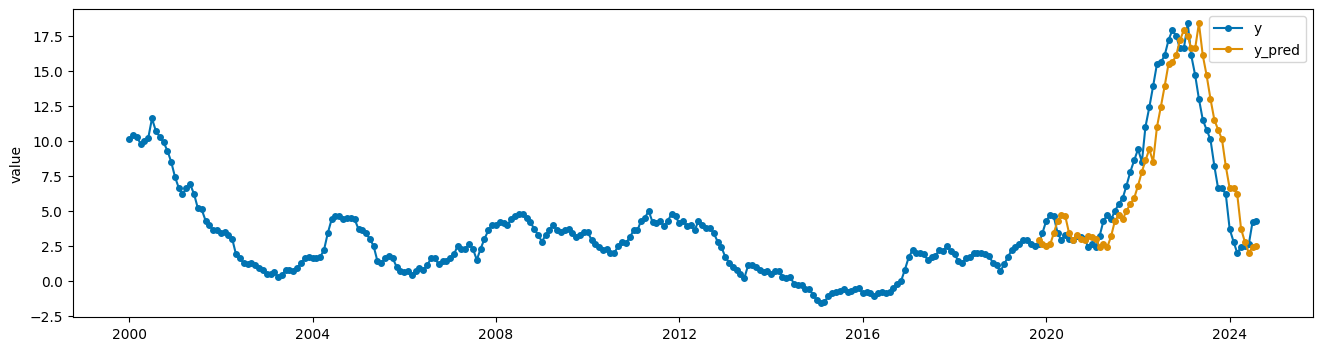

<Figure size 640x480 with 0 Axes>

In [16]:
from sktime.forecasting.naive import NaiveForecaster

evaluate_model(model = NaiveForecaster(strategy="last"), data=df, horizon=3, plot_forecasts=True, analyze_residuals=False)

MAE: 4.91
MASE: 14.42


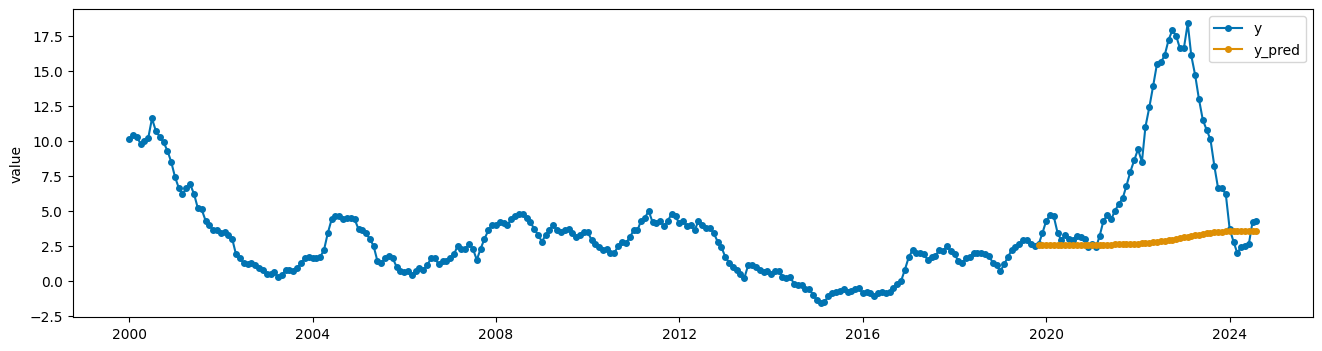

<Figure size 640x480 with 0 Axes>

In [17]:
evaluate_model(model = NaiveForecaster(strategy="mean"), data=df, horizon=3, plot_forecasts=True, analyze_residuals=False)

Results from our first baselines look reasonable. Let's see how ETS and ARIMA will compare.

**Exercise 4 (0.75 points)**

1. Perform forecasting using the AutoETS algorithm in the damped trend variant, based on the `statsforecast` implementation ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoETS.html)). Plot forecasts and perform residuals analysis.
2. Similarly, use AutoARIMA for forecasting ([documentation](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.statsforecast.StatsForecastAutoARIMA.html)). If you didn't detect seasonality earlier, pass appropriate option to ignore SARIMA variants.
3. Comment on the results:
   - did you manage to outperform the baselines?
   - which of the models is better, and what may this mean?
   - which model is correct, at least approximately, i.e. has normally distributed, non-autocorrelated errors?
   - are the results of the best model, subjectively, good enough?

As before, use 3 month forecast horizon.

MAE: 1.57
MASE: 4.59


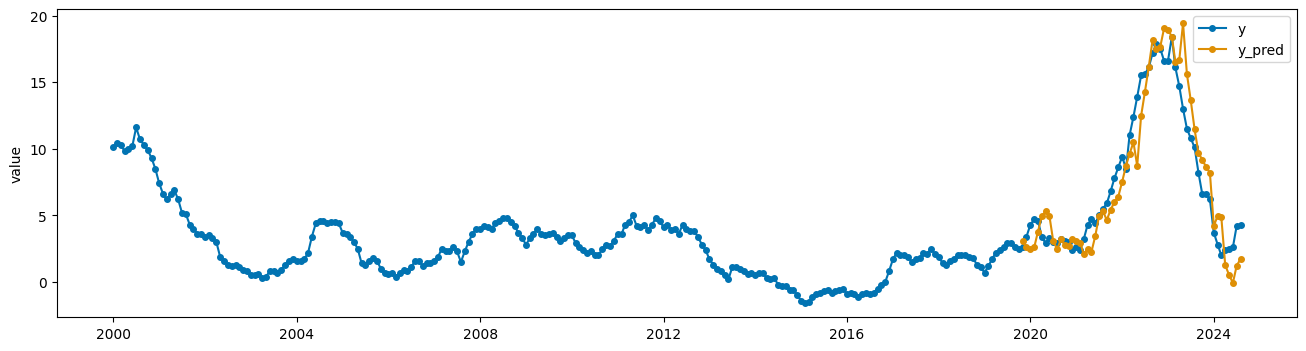

<Figure size 640x480 with 0 Axes>

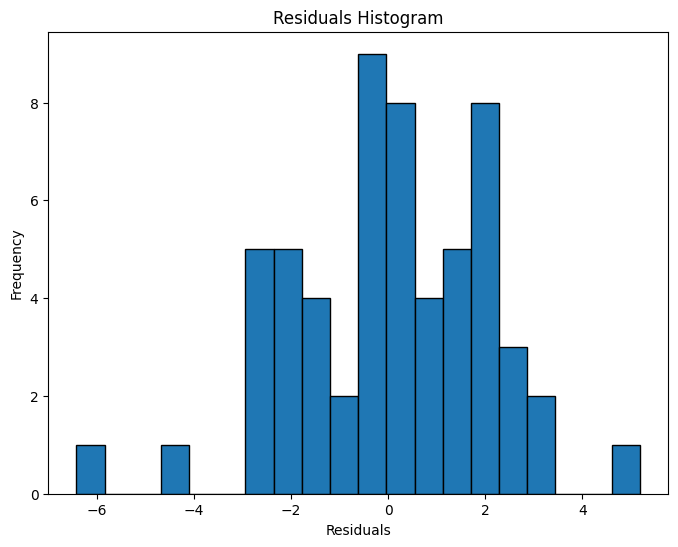

Anderson-Darling Test Result: AndersonResult(statistic=0.33720541756830613, critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.02277324587646842, scale=2.0274209256399414)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Residuals follow the normal distribution.

Ljung-Box Test Results:       lb_stat     lb_pvalue
10  62.687154  1.119922e-09


In [18]:
from sktime.forecasting.statsforecast import StatsForecastAutoETS

evaluate_model(model = StatsForecastAutoETS(damped=True), data=df, horizon=3, plot_forecasts=True, analyze_residuals=True)

MAE: 1.69
MASE: 4.93


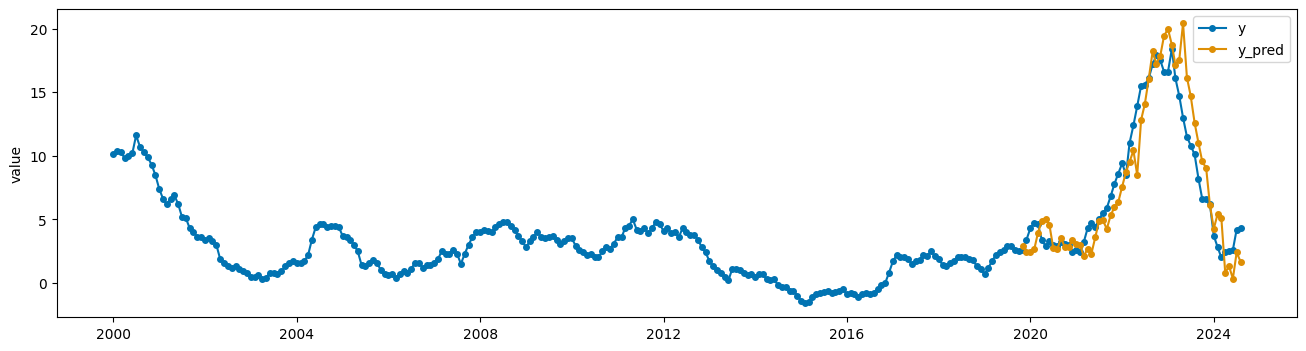

<Figure size 640x480 with 0 Axes>

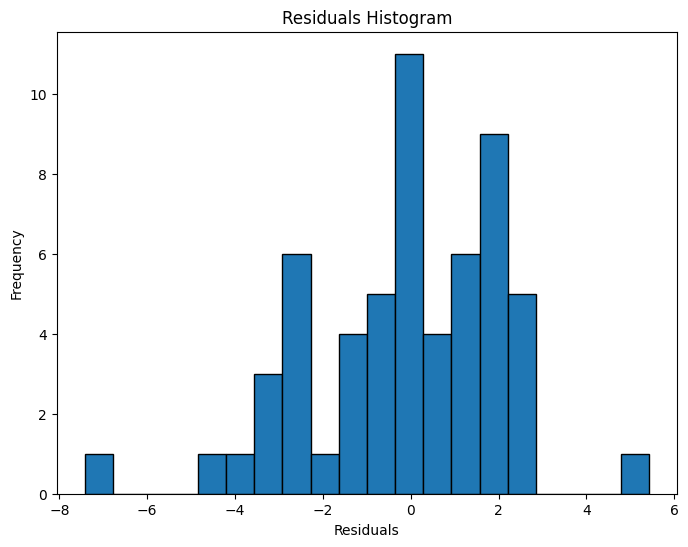

Anderson-Darling Test Result: AndersonResult(statistic=0.8501642231127917, critical_values=array([0.543, 0.618, 0.741, 0.865, 1.029]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.12178695611476935, scale=2.2079482737485634)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Residuals don't follow the normal distribution.

Ljung-Box Test Results:       lb_stat     lb_pvalue
10  81.263214  2.837585e-13


In [19]:
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

evaluate_model(model = StatsForecastAutoARIMA(seasonal=False), data=df, horizon=3, plot_forecasts=True, analyze_residuals=True)

// comment here

Yes, both statistical models: ARIMA and ETS, were able to outperform the baselines considering both metrics: MAE and MASE. It's mostly caused by the huge chart variability in predicted years, as they include massive inflation growth in pandemic time.

The best values for MAE and MASE are given by ETS. It may be this way because of small data and strong trends in this time frame, which suit better the ETS model and are not good for ARIMA.

None of the models is correct. Anderson-Darling Test for ETS implise, it has normal distribution, but really low p-value of Ljung-Box Test show big autocorrelation still present in the model. For ARIMA neither Anderson-Darling Test shows normal distribution (although the bars on the chart doesn't look much worse, than the ones for ETS), nor Ljung-Box Test shows lack of autocorrelation.

The results of the best model are definitely not good enough. MASE is way above 1, and really small p-value of Ljung-Box Test clearly indicates, the model hasn't fully captured the structure of the data.

// comment here - end

3 month horizon is quite short, generally speaking. The question is, what about long-term forecasting, e.g. half-yearly or yearly? They are equally, or even more interesting and relevant, e.g. for national budget planning.

**Exercise 5 (0.75 points)**

Perform forecasting for 6-month and yearly horizons, using:
- both baselines
- ETS
- ARIMA

For the best model, plot the forecasts and perform residuals analysis.

Comment:
- are there differences between models, compared to the 3-month forecasting?
- how does the quality of forecasts change for longer horizons?
- in your opinion, are those models useful at all for long-term forecasting?

In [20]:
horizon = 6

print("Last value:")
evaluate_model(model = NaiveForecaster(strategy="last"), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nMean value:")
evaluate_model(model = NaiveForecaster(strategy="mean"), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nAutoETS:")
evaluate_model(model = StatsForecastAutoETS(damped=True), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nAutoARIMA:")
evaluate_model(model = StatsForecastAutoARIMA(seasonal=False), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

Last value:
MAE: 3.45
MASE: 10.11

Mean value:
MAE: 5.18
MASE: 15.51

AutoETS:
MAE: 3.08
MASE: 9.05

AutoARIMA:
MAE: 3.48
MASE: 10.17



AutoETS:
MAE: 3.08
MASE: 9.05


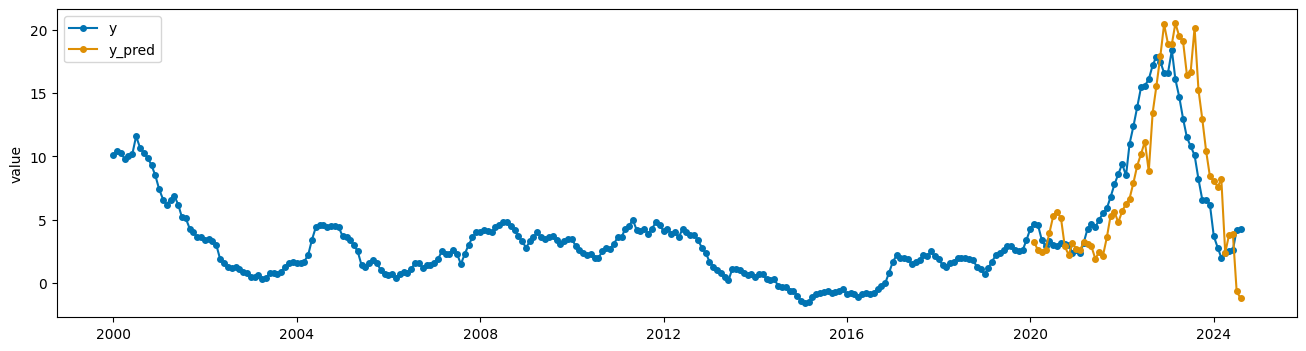

<Figure size 640x480 with 0 Axes>

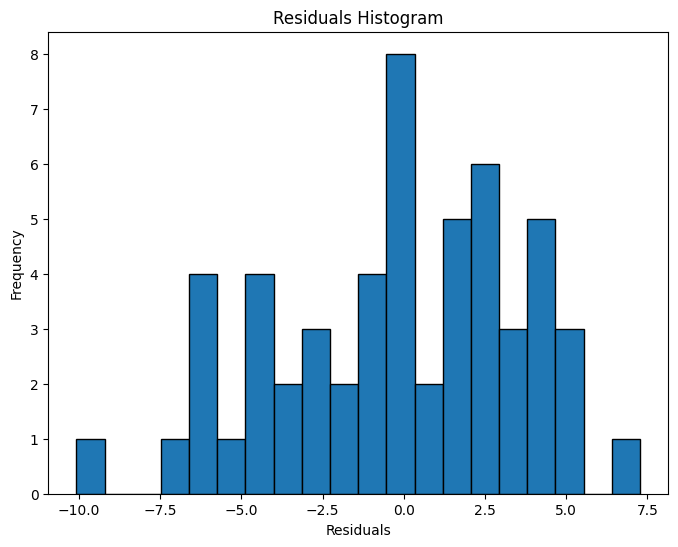

Anderson-Darling Test Result: AndersonResult(statistic=0.44542095541532234, critical_values=array([0.541, 0.616, 0.739, 0.862, 1.026]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-0.17814502656661185, scale=3.818388657331927)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Residuals follow the normal distribution.

Ljung-Box Test Results:        lb_stat     lb_pvalue
10  141.653839  1.930686e-25


In [21]:
print("\nAutoETS:")
evaluate_model(model = StatsForecastAutoETS(damped=True), data=df, horizon=horizon, plot_forecasts=True, analyze_residuals=True)

// comment here

For longer forecasting horizon, ETS delivers still the best results from all tested forcasting methods, including baselines. Yet the quality of the forecast has gotten worse. The indicators like MAE and MASE grew even higher and Ljung-Box's p-value is even lower, which indicates even worse capture of data by the model.

It looks like, long-term forecassting of financial data is not the storngest side of these models. All the indicators speak against them. To be fair to them, they've been tested in really abnormal time frame, yet still I wouldn't use them for forecasting of financial data, especially for the long-term. Although it's interesting, that both models were able either to outperform, or deliver as least similar results to the baselines.

// comment here - end

## Forecasting network traffic

And now for something completely different. Network traffic forecasting is necessary for virtual machines (VMs) scaling, adding more servers to handle load in parallel. This is done more and more frequently by using ML models, based on time series forecasting, to scale more intelligently and avoid manually tweaking scaling rules. This is called predictive scaling, and is implemented by e.g. [AWS](https://docs.aws.amazon.com/autoscaling/ec2/userguide/ec2-auto-scaling-predictive-scaling.html), [GCP](https://cloud.google.com/compute/docs/autoscaler/predictive-autoscaling), and [Azure](https://learn.microsoft.com/en-us/azure/azure-monitor/autoscale/autoscale-predictive). There are also solutions for Kubernetes, both [open source](https://predictive-horizontal-pod-autoscaler.readthedocs.io/en/latest/) and [proprietary](https://keda.sh/blog/2022-02-09-predictkube-scaler/). Time series forecasting allows lower latency and lower costs, automatically turning off machines when low demand is predicted.

Wikipedia and Google hosted [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting), where the goal was predicting the network traffic on particular Wikipedia pages. It's a really massive dataset, so we will operate on a simplified problem, where we have a total number of requests to the Wikipedia domain in millions.

Typical characteristics of such tasks are:
- short-term forecasting
- high frequency
- dynamically changing, noisy data (e.g. bot activity, web scraping)
- frequent model retraining
- high need for automatization, lack of manual model analysis

,value
2015-07-01,148.672476
2015-07-02,149.593840
2015-07-03,141.164198
2015-07-04,145.612937
2015-07-05,151.495372
...,...
2017-09-06,172.354146
2017-09-07,180.731284
2017-09-08,136.754670
2017-09-09,132.359512


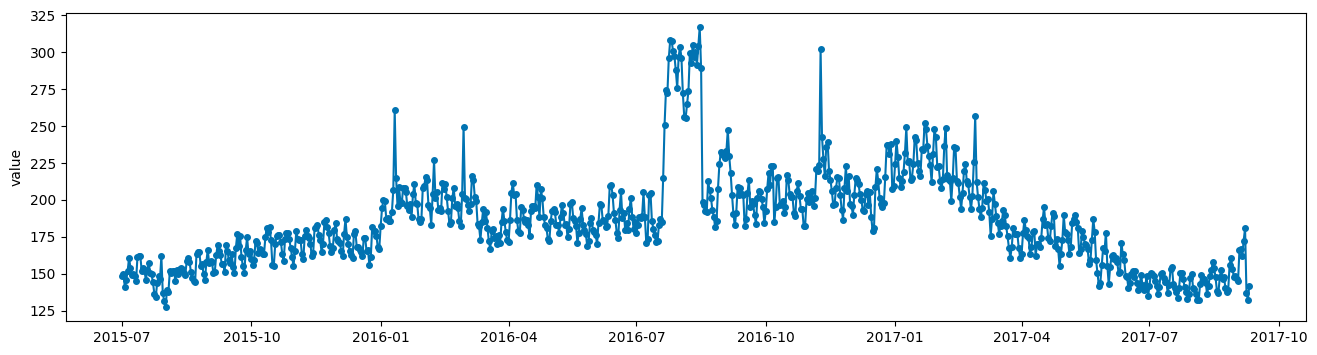

In [73]:
df = pd.read_parquet("wikipedia_traffic.parquet")
df = df.set_index("date").to_period(freq="d")
plot_series(df)
df

**Exercise 6 (1 point)**

For 1-day horizon, train models and evaluate them (similarly to the previous dataset, with 20% test data):
- two baselines
- ETS with damped trend
- ARIMA (without seasonality)
- SARIMA

Comment:
- based on those results, is there a seasonality here?
- did you manage to outperform the baseline?

In [74]:
horizon = 1

print("Last value:")
evaluate_model(model = NaiveForecaster(strategy="last"), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nMean value:")
evaluate_model(model = NaiveForecaster(strategy="mean"), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nAutoETS:")
evaluate_model(model = StatsForecastAutoETS(damped=True), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nAutoARIMA:")
evaluate_model(model = StatsForecastAutoARIMA(seasonal=False), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nAutoSARIMA:")
evaluate_model(model = StatsForecastAutoARIMA(seasonal=True), data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

Last value:
MAE: 6.63
MASE: 0.78

Mean value:
MAE: 33.04
MASE: 3.92

AutoETS:
MAE: 6.63
MASE: 0.78

AutoARIMA:
MAE: 5.27
MASE: 0.62

AutoSARIMA:
MAE: 5.27
MASE: 0.62


// Comment here

This time the best forecast is given by ARIMA, which also outperformed the baselines, and this quite significantly. In my opinion, the trend this time is not that strong which suits ARIMA better.

AutoSARIMA wasn't able to find proper parameters for seasonality, and the result of it is exactly the same as for AutoARIMA. This is the indication that there is no seasonality in the data.

// Comment here - end

But maybe we can do better? This data is highly volatile, with high variance, which is particularly bad for ARIMA models. Let's apply the variance-stabilizing transform then. We have only positive values here, so there are no numerical problems.

Note that `Pipeline` from sktime is needed here ([documentation](https://www.sktime.net/en/stable/api_reference/pipeline.html)), which will automatically invert the transformation during prediction. Sometimes models are evaluated on the transformed data, but we are generally interested in the forecasting quality on the data in its raw form. The goal of transformations is to make the training easier for the model.

**Exercise 7 (0.5 points)**

Create a pipeline, consisting of a transform object and AutoARIMA model (without seasonality). Try out the following transformations ([documentation](https://www.sktime.net/en/stable/api_reference/transformations.html)):
- log
- sqrt
- Box-Cox

Comment, whether the result is better after the transformation or not.

In [75]:
from sktime.pipeline import make_pipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.exponent import SqrtTransformer
from sktime.transformations.series.boxcox import BoxCoxTransformer

horizon = 1

print("Log + AutoARIMA:")
evaluate_model(model = make_pipeline(LogTransformer(), StatsForecastAutoARIMA(seasonal=False)), 
               data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nSqrt + AutoARIMA:")
evaluate_model(model = make_pipeline(SqrtTransformer(), StatsForecastAutoARIMA(seasonal=False)), 
               data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)

print("\nBoxCox + AutoARIMA:")
evaluate_model(model = make_pipeline(BoxCoxTransformer(), StatsForecastAutoARIMA(seasonal=False)), 
               data=df, horizon=horizon, plot_forecasts=False, analyze_residuals=False)


Log + AutoARIMA:
MAE: 4.99
MASE: 0.59

Sqrt + AutoARIMA:
MAE: 5.04
MASE: 0.60

BoxCox + AutoARIMA:
MAE: 4.90
MASE: 0.58


// comment here

All variance-stabilizing methods improve the quality of forecasting. The best improvement has been produced by the Swiss army knive among this type of transformations, namely BoxCox.

// commen here - end

## Sales forecasting

Arguably the most common application of time series forecasting is predicting sales, demand, costs etc., so all typical operational indicators of a company. Basically every company has to do this, therefore even basic software like Excel or PowerBI have built-in capabilities for time series forecasting.

We will focus on a task definitely vital for the Italian economy, i.e. the pasta sales. Dataset has been gathered by the Italian scientists for [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0957417421005431?via%3Dihub). Data covers years 2014-2018, from 4 companies offering various pasta-based products. They also contain data about promotions for particular products. There are also missing values, which must be imputed.

Typical characteristics of this type of data are:
- positive trend, smaller or larger (changing in time)
- strong seasonality, often more than one
- highly sensitive to recurring events, e.g. weekends or holidays
- large outliers, often related to events
- relatively low frequency, daily or less frequent
- often long forecasting horizons, e.g. monthly, quarterly, yearly
- rich exogenous variables

**Exercise 8 (1 point)**

1. Read the data from `"italian_pasta.csv"` file
2. Select columns from company B1 (they have `"B1"` in their name) and `"DATE"` column.
3. Create the `value` column with total pasta sales, i.e. sum of columns with `"QTY"` in name.
4. Create the `num_promos` column with total number of promotions, i.e. sum of columns with `"PROMO"` in name.
5. Leave only columns `"DATE"`, `"value"` and `"num_promos"`.
6. Create index with type `datetime`:
   - change type of `"DATE"` colum to `datetime`
   - set its frequency as daily, `"d"`
   - set it as index
7. Split the data into:
   - `y` variable, `pd.Series` created from the `"value"` column, our main time series values
   - `X` variable, `pd.Series` created from the `"num_promos"` column, exogenous variables
8. Impute the missing values in exogenous variables with zeros, assuming that by default there are no promotions.
9. Plot the `y` time series. Remember to set the appropriate title.

<Figure size 1000x600 with 0 Axes>

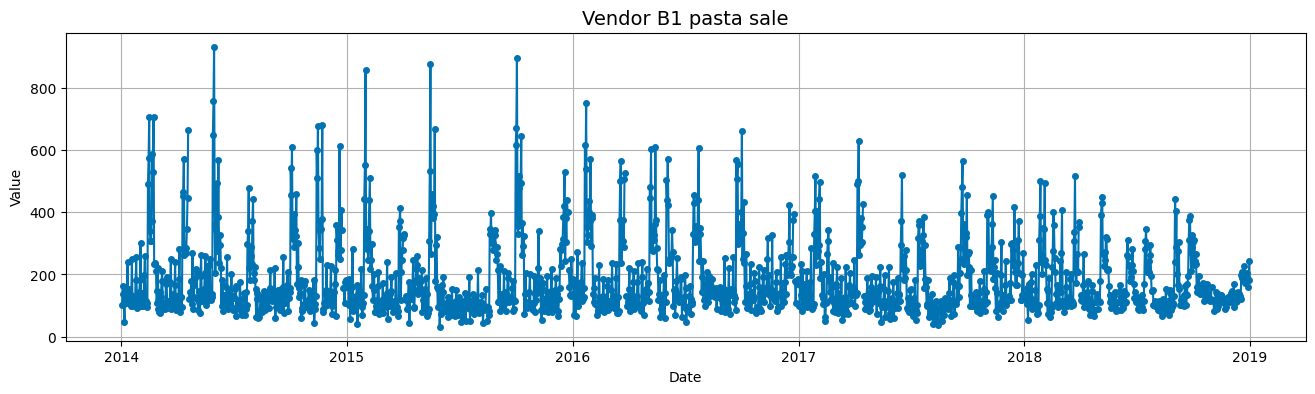

In [25]:
df = pd.read_csv("italian_pasta.csv", index_col="DATE", parse_dates=True)
df = df.filter(like='_B1_')
df["value"] = df.filter(like="QTY").sum(axis=1)
df["num_promos"] = df.filter(like="PROMO").sum(axis=1)
df = df[["value", "num_promos"]]

df.index = pd.to_datetime(df.index)
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(full_index)

y = df['value']

X = df['num_promos']
X = X.fillna(0)

# Plot the 'y' time series
plt.figure(figsize=(10, 6))
plot_series(y)

# Add title and labels
plt.title("Vendor B1 pasta sale", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

We are interested in long-term forecasting. We assume that our client, an italian pasta maker, has the historical data from years 2014-2017 and wants to forecast the sales for 2018. Such information is required e.g. to make contracts for long-term supply of raw materials and next year production plans. From ML perspective this hard, since there is only a single temporal train-test split with long horizon, instead of expanding window, but it's faster.

We will use the `evaluate_pasta_sales_model` function for evaluation.

**Exercise 9 (1 point)**

Implement the missing parts of the evaluation function:
1. Split `y` into training and testing set with time split. Test set starts at `2018-01-01`.
2. If user passes `X`, split it in the same way.
3. Impute the missing values in `y`, using `Imputer` from sktime ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.impute.Imputer.html)) with `ffill` strategy (copy last known value).
4. Train the model (remember to pass `X`) and perform prediction.
5. Evaluate it using MAE and MASE functions ([documentation](https://www.sktime.net/en/stable/api_reference/performance_metrics.html)). Print the results rounded to 2 decimal places.
6. Copy the code for `analyze_residuals` from exercise 3.

In [70]:
from typing import Optional

import numpy as np
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.impute import Imputer


def evaluate_pasta_sales_model(
    model,
    data: pd.Series,
    X: Optional[np.ndarray] = None,
    plot_forecasts: bool = False,
    analyze_residuals: bool = False,
) -> None:
    y_train = data[:'2017-12-31']
    y_test = data['2018-01-01':]

    if X is not None:
        X_train = X[:'2017-12-31']
        X_test = X['2018-01-01':]
    else:
        X_train = None
        X_test = None

    # impute
    imputer = Imputer(method="ffill")
    y_train = imputer.fit_transform(y_train)
    y_test = imputer.transform(y_test)

    # train and predict
    horizon = np.arange(1, 366)
    model.fit(y_train, X=X_train,fh=horizon)
    y_pred = model.predict(fh=horizon, X=X_test)


    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mase = mean_absolute_scaled_error(y_true=y_test, y_pred=y_pred, y_train=y_train)

    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}")
    print(f"MASE: {mase:.2f}")

    if plot_forecasts:
        y_true = data[y_pred.index]
        plot_series(data, y_pred, labels=["y", "y_pred"])
        plt.show()
        plt.clf()
    
    if analyze_residuals:
        y_true = data[y_pred.index]
        residuals = y_true - y_pred

        plt.figure(figsize=(8, 6))
        plt.hist(residuals, bins=20, edgecolor='black')
        plt.title("Residuals Histogram")
        plt.xlabel("Residuals")
        plt.ylabel("Frequency")
        plt.show()

        ad_test = anderson(residuals, dist="norm")
        print("Anderson-Darling Test Result:", ad_test)
        if ad_test.statistic < ad_test.critical_values[2]:
            print("\nResiduals follow the normal distribution.\n")
        else:
            print("\nResiduals don't follow the normal distribution.\n")

        residuals = residuals[~residuals.isna()]

        ljung_box_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
        print(f"Ljung-Box Test Results: {ljung_box_test}")

        
        

**Exercise 10 (1.5 points)**

Perform the forecasting using the following models:
- two baselines
- ETS with damped trend
- ARIMA
- SARIMA with 30-day seasonality
- ARIMAX
- SARIMAX with 30-day seasonality

For the best model also try the log, sqrt and Box-Cox transformations.

For the final model plot the forecasts and perform residuals analysis.

Comment:
- did you outperform the baseline?
- does the final model use seasonality and/or exogenous variables (data about promotions)?
- was it worth it to use the variance-stabilizing transformation?
- comment on the general behavior of the model on the test set, based on the forecast plot
- is the model unbiased (normally distributed residuals with zero mean), without autocorrelation, or can this be improved?

In [34]:
print("Last value:")
evaluate_pasta_sales_model(model = NaiveForecaster(strategy="last"), data=y, X=None, plot_forecasts=False, analyze_residuals=False)

print("\nMean value:")
evaluate_pasta_sales_model(model = NaiveForecaster(strategy="mean"), data=y, X=None, plot_forecasts=False, analyze_residuals=False)

print("\nETS:")
evaluate_pasta_sales_model(model = StatsForecastAutoETS(damped=True), data=y, X=None, plot_forecasts=False, analyze_residuals=False)

print("\nARIMA:")
evaluate_pasta_sales_model(model = StatsForecastAutoARIMA(seasonal=False), data=y, X=None, plot_forecasts=False, analyze_residuals=False)

print("\nSARIMA 30d:")
evaluate_pasta_sales_model(model = StatsForecastAutoARIMA(seasonal=True, sp=30), data=y, X=None, plot_forecasts=False, analyze_residuals=False)

print("\nARIMAX:")
evaluate_pasta_sales_model(model = StatsForecastAutoARIMA(seasonal=False), data=y, X=X, plot_forecasts=False, analyze_residuals=False)

print("\nSARIMAX 30d:")
evaluate_pasta_sales_model(model = StatsForecastAutoARIMA(seasonal=True, sp=30), data=y, X=X, plot_forecasts=False, analyze_residuals=False)


Last value:
MAE: 57.60
MAPE: 0.31
MASE: 0.87

Mean value:
MAE: 71.07
MAPE: 0.52
MASE: 1.08

ETS:
MAE: 64.98
MAPE: 0.44
MASE: 0.98

ARIMA:
MAE: 70.77
MAPE: 0.51
MASE: 1.07

SARIMA 30d:
MAE: 69.95
MAPE: 0.51
MASE: 1.06

ARIMAX:
MAE: 43.56
MAPE: 0.28
MASE: 0.66

SARIMAX 30d:
MAE: 43.94
MAPE: 0.29
MASE: 0.67


In [45]:
print("\nLog + ARIMAX:")
evaluate_pasta_sales_model(model = make_pipeline(LogTransformer(), StatsForecastAutoARIMA(seasonal=False)), data=y, X=X, plot_forecasts=False, analyze_residuals=False)

print("\nSqrt + ARIMAX")
evaluate_pasta_sales_model(model = make_pipeline(SqrtTransformer(), StatsForecastAutoARIMA(seasonal=False)), data=y, X=X, plot_forecasts=False, analyze_residuals=False)

print("\nBoxCox + ARIMAX")
evaluate_pasta_sales_model(model = make_pipeline(BoxCoxTransformer(), StatsForecastAutoARIMA(seasonal=False)), data=y, X=X, plot_forecasts=False, analyze_residuals=False)



Log + ARIMAX:
MAE: 42.25
MAPE: 0.27
MASE: 0.64

Sqrt + ARIMAX
MAE: 45.88
MAPE: 0.31
MASE: 0.70

BoxCox + ARIMAX
MAE: 40.45
MAPE: 0.25
MASE: 0.61


MAE: 40.45
MAPE: 0.25
MASE: 0.61


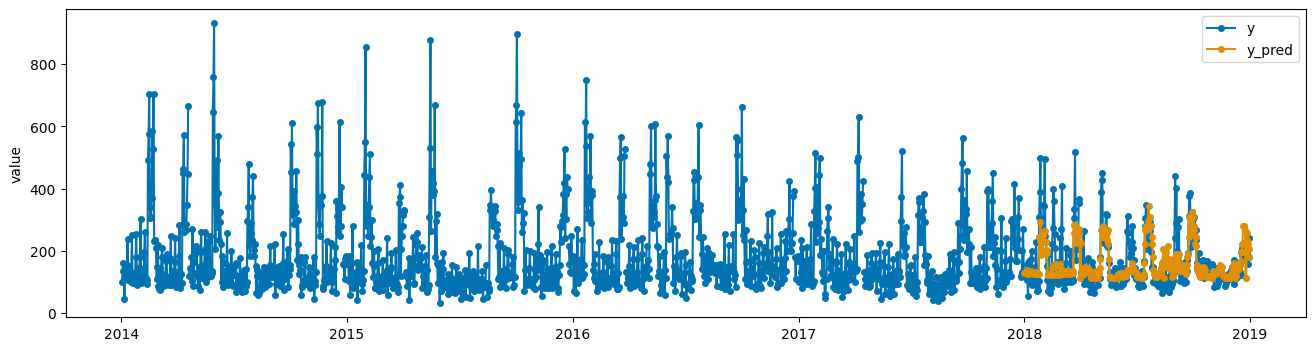

<Figure size 640x480 with 0 Axes>

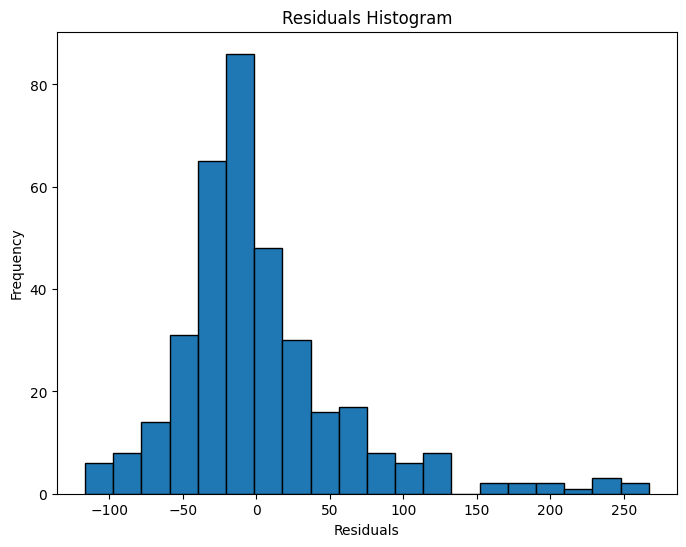

Anderson-Darling Test Result: AndersonResult(statistic=nan, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.680965834441783, scale=59.51782326356101)
 success: False
 message: 'Optimization converged to parameter values that are inconsistent with the data.')

Residuals don't follow the normal distribution.

Ljung-Box Test Results:        lb_stat     lb_pvalue
10  205.368861  1.223508e-38


In [71]:
evaluate_pasta_sales_model(model = make_pipeline(BoxCoxTransformer(), StatsForecastAutoARIMA(seasonal=False)), data=y, X=X, plot_forecasts=True, analyze_residuals=True)


// Comment here

This time all of the models, but the ones using exogenous variables, produced worse forecasts than the baseline: last value. Only introducing of the exogenous variables allowed us to beat the baseline, and we've done it by a huge margin.

SARIMAX delivered a bit worse results than ARIMAX, so I'm assuming there is no clear seasonality and further considerations will be presented only with regard to ARIMAX.

Variance-stabilizing transformation rendered even better results, reducing the MAE and MASE metrics for ARIMAX to 40.45 and 0.61 respectively. Among the tested variance-stabilizing transformations only the one using the square-rooting worsen the results, other two: log and BoxCox, offered a significant improvement.

From the chart we can see, that exogenous variables allow the prediction line to follow the actual values rather well. At least we can noticed that some from the peaks of the actual data are reflected in the predicion, and the "baseline" of the plot stays for both lines similar. Running this prediction without exogenous data would leave as with rather straight line following the "baseline", and the peaks wouldn't be adressed at all, cause the forecasting horizon is really long.

Anderson-Darling Test presents a chart, which is really close to the natural distribution, yet is a bit right-skewed and didn't satisfy the selected significance level, so the response from the automatized test is negative. P-value from Ljung-Box test is very small, so there shouldn't be an autocorrelatino in data.

// Comment here - end

Exogenous variables can be expanded with feature engineering. For example, the behavior of clients is quite different during weekends and holidays. Typically sales rise quite sharply before and after days when stores are closed, and falls to exactly zero when they have to be closed.

**Exercise 11 (0.75 points)**

1. Create a list of variables for holidays using `HolidayFeatures` ([documentation](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.series.holiday.HolidayFeatures.html)):
   - use `country_holidays` function from the holidays library
   - remember that we are processing italian data, with country identifier `"IT"`
   - include weekends as holidays
   - create a single variable "is there a holiday" (`return_dummies` and `return_indicator` options)
2. Add those features to our exogenous variables `X`. Use `pd.merge` function, `left_index` and `right_index` options may be useful.
3. Train the ARIMAX model (or SARIMAX, if you detected seasonality before). Use the best transformation from the previous exercise.
4. Comment on the results, and compare them to the previous ones.


ARIMAX:
MAE: 40.31
MAPE: 0.25
MASE: 0.61


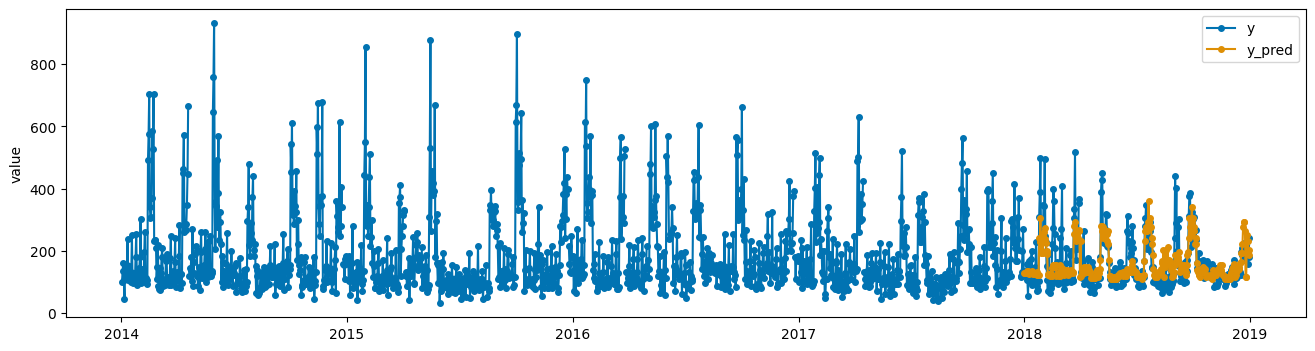

<Figure size 640x480 with 0 Axes>

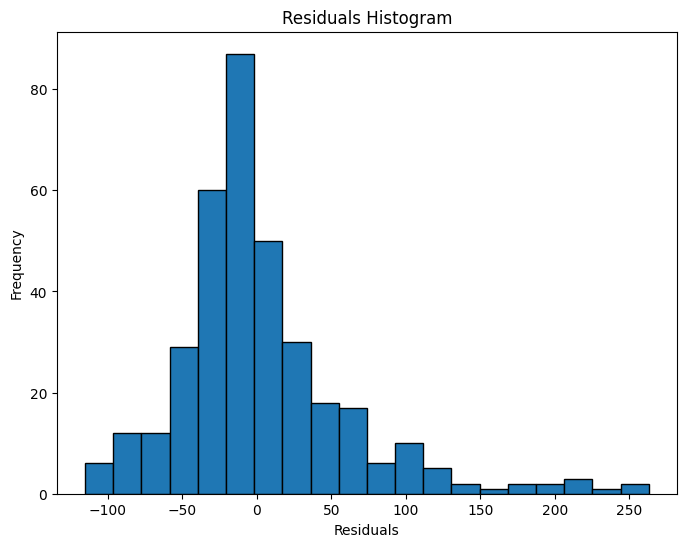

Anderson-Darling Test Result: AndersonResult(statistic=nan, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.08 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.7102850787910837, scale=58.97280317158332)
 success: False
 message: 'Optimization converged to parameter values that are inconsistent with the data.')

Residuals don't follow the normal distribution.

Ljung-Box Test Results:        lb_stat     lb_pvalue
10  206.381559  7.519046e-39


In [72]:
from sktime.transformations.series.holiday import HolidayFeatures
from holidays import country_holidays

italian_holidays = country_holidays("IT")

holiday_transformer = HolidayFeatures(
    calendar=italian_holidays,
    include_weekend=True,
    return_dummies=False,
    return_indicator=True
)

holiday_features = holiday_transformer.fit_transform(X)

X_hol = X.to_frame().merge(holiday_features, left_index=True, right_index=True)

print("\nARIMAX:")
evaluate_pasta_sales_model(model = make_pipeline(BoxCoxTransformer(), StatsForecastAutoARIMA(seasonal=False)), data=y, X=X_hol, plot_forecasts=True, analyze_residuals=True)



// comment here

Additional exogenous variables in the form of calendar days hasn't improve the forecast quality. Apparently the sell of pasta isn't strongly correlated with working and non-working days.

The analysis of residuals gives us the same reults as before. Their distribution is close to be normal, skewed right and not enough to pass the test. Ljung-Box Test with low p-value points to the conclusion, that the data is not autocorrelated.

// comment here - end